In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
import itertools as it
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import random as rd

import threading
import multiprocessing


# for Jupyter Notebook
# %matplotlib notebook

# for vscode    
%matplotlib widget        

## Graph Helper

In [18]:
def create_network_graph(num_nodes:int = 50) -> nx.Graph:
    G_scale_free = nx.scale_free_graph(num_nodes)
    
    # G_network = G_scale_free.reverse()
    G_network = G_scale_free.to_undirected()
    
    G_network.remove_edges_from(nx.selfloop_edges(G_network))
    G_network.remove_nodes_from(list(nx.isolates(G_network)))

    return G_network

In [19]:
def draw_graph(G: nx.Graph, G_type: str = "big"):
    if G_type == "big":
        pos = graphviz_layout(G, prog="neato")
        plt.figure(figsize=(40, 40))
        nx.draw(G, pos, arrows=False, node_color="grey", edge_color="black", with_labels=False, node_size=50)
    elif G_type == "small":
        pos = graphviz_layout(G, prog="neato")
        plt.figure(figsize=(10, 10))
        nx.draw(G, pos, arrows=False, node_color="grey", edge_color="black", with_labels=False, node_size=100)

    plt.show()
    plt.savefig("graph.svg")


def draw_colored_graph(G: nx.Graph):
    pos = graphviz_layout(G, prog="neato")
    plt.figure(figsize=(10, 10))

    cmap = plt.cm.jet  
    cmaplist = [cmap(i) for i in range(cmap.N)]
    rd.shuffle(cmaplist)

    color = [cmaplist[data["opinion"]%cmap.N] for _, data in G.nodes(data=True)]
    nx.draw(G, pos, arrows=False, node_color=color, edge_color="black", with_labels=False, node_size=100)

    plt.show()

## Opinion Diversity Simulation

#### Diversity Index (TODO)

In [20]:
def calc_diversity_index(G: nx.Graph):
    avg_M_G = 0 
    Delta_G = avg_M_G / G.number_of_nodes() 
    return Delta_G

#### Simulation Logic

In [21]:
def calc_opinion_diversity(G: nx.Graph):
    opinion_count = {}
    for node in G.nodes():
        opinion = str(G.nodes[node]['opinion'])
        if opinion not in opinion_count:
            opinion_count[opinion] = 0
        opinion_count[opinion] += 1

    total_nodes = G.number_of_nodes()
    diversity_index = sum((count / total_nodes) ** 2 for count in opinion_count.values())
    return 1 - diversity_index

def kumulative_opinion_diversity(G: nx.Graph, it_counter:int, index_sum: list):
    return index_sum / it_counter


def init_opinions(G: nx.Graph, num_opinions: int = 2):
    # initialize the graph with random opinions
    for node in G.nodes():
        G.nodes[node]['opinion'] = np.random.randint(0, num_opinions)
    G.graph['diversity_index_sum'] = 0
    return G

def iterate_dispersion(G: nx.Graph, opinion_counter, r):
    for node in G.nodes():
        do_inovate = np.random.rand() < r
        if do_inovate:
            G.nodes[node]['next_opinion'] = next(opinion_counter)

        else:
            neighbors = list(G.neighbors(node))
            # neighbors.append(node)  # include self in neighbors
            neighbor_opinions = [G.nodes[neigh]['opinion'] for neigh in neighbors]
            G.nodes[node]['next_opinion'] = np.random.choice(neighbor_opinions)
    for node in G.nodes():
        G.nodes[node]['opinion'] = G.nodes[node]['next_opinion']
    return G

def simulate_opinion_dispersion(G: nx.Graph, iterations: int = 100, num_opinions: int = 2, r: float = 0.05, cutoff_div_index: int = 50, verbose: bool = False):
    if verbose:
        print(f"[Thread] {threading.current_thread().name}")
        print(f"[Process] PID {multiprocessing.current_process().pid}")

    G = init_opinions(G, num_opinions)
    opinion_counter = it.count(num_opinions)
    for i in range(iterations):
        G = iterate_dispersion(G, opinion_counter, r)
        kum_diversity_index = 0
        if i > cutoff_div_index:
            diversity_index = calc_opinion_diversity(G)
            G.graph['diversity_index_sum'] += diversity_index
            kum_diversity_index = kumulative_opinion_diversity(G, (i+1)-cutoff_div_index, G.graph['diversity_index_sum'])
    return G, kum_diversity_index

#### Simulation Animation


In [22]:
def animate_simulation(G: nx.Graph, iterations: int = 100, fps: int = 1, num_opinions: int = 2, r: float = 0.05, cutoff_div_index: int = 50):
    pos = graphviz_layout(G, prog="neato")
    fig, ax = plt.subplots(figsize=(20, 15))
    fig.set_frameon(False)  # ❌ Remove box
    # Create a 3-row, 2-column layout
    gs = gridspec.GridSpec(3, 2, width_ratios=[5, 2], height_ratios=[1, 1, 1], wspace=0.3)

    # Left: big square graph area (occupies all 3 rows)
    ax_left = fig.add_subplot(gs[:, 0])
    # ax_left.set_title("Graph")
    ax_left.set_frame_on(False)  # ❌ Remove box

    # Right: middle row only (1/3 height, visually half-height compared to tall square)
    ax_right = fig.add_subplot(gs[1, 1])
    ax_right.set_frame_on(False)  # ❌ Remove box
    ax_right.set_xticks([])
    ax_right.set_ylim(0, 1)

    ax = [ax_left, ax_right]

    cmap = plt.cm.jet  # define the colormap
    cmaplist = [cmap(i) for i in range(cmap.N)]
    rd.shuffle(cmaplist)
    get_colors = lambda G: [cmaplist[data["opinion"]%cmap.N] for _, data in G.nodes(data=True)]

    opinion_counter = it.count(num_opinions)
    graph_plt = nx.draw(G, pos, ax[0], arrows=False, node_color="grey", edge_color="black", with_labels=False, node_size=150)
    # text_plt = ax[0].text(1.0, 1.0, "Initialize")
    bars = ax[1].bar([0, 1], [0.5, 0.5], width=0.6, color=["#1f77b4", "#ff7f0e"], label=["$D_t(G)$", "$D_\infty (G)$"])

    # Achsen- und Rahmenanpassung
    ax[1].set_xticks([0, 1], ["$D_t (G)$", "$D_\infty (G)$"], fontsize=20)               # Keine x-Achsenbeschriftung
    ax[1].set_frame_on(False)          # Keine Umrandung der Plotbox
    ax[1].set_title("")                # Kein Titel
    ax[1].grid(False)                  # Kein Grid
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['bottom'].set_visible(False)
    ax[1].set_ylim(0, 1)


    

    def init(G):
        G = init_opinions(G, num_opinions)
        colors = get_colors(G) 
        graph_plt.set_color(colors)
        return graph_plt

    def update(i, G, opinion_counter):
        if i < 15:
            return graph_plt
        i -= 15
        if i == iterations:
            ani.event_source.stop()
            return graph_plt
 
        G = iterate_dispersion(G, opinion_counter, r)
        colors = get_colors(G) 
        graph_plt.set_color(colors)

        diversity_index = calc_opinion_diversity(G)
        kum_diversity_index = 0
        if i > cutoff_div_index:
            G.graph['diversity_index_sum'] += diversity_index
            kum_diversity_index = kumulative_opinion_diversity(G, (i+1)-cutoff_div_index, G.graph['diversity_index_sum'])
        # text_plt.set_text(f"Propagte")
        bars[0].set_height(diversity_index)
        bars[1].set_height(kum_diversity_index)
        
    ani = animation.FuncAnimation(
        fig, 
        update,
        fargs=(G, opinion_counter,), 
        init_func=lambda: init(G), interval=1000*(1/fps), blit=False, save_count=100)
    
    plt.show()
    return ani


def save_animation(ani, filename: str = "opinion_dispersion.gif"):
    writergif = animation.PillowWriter(fps=5, bitrate=2000)
    ani.save(filename, writer=writergif)
    print(f"Animation saved as {filename}")

#### Small Test Graphs

In [23]:
# G = create_network_graph(num_nodes=10)
# G = init_opinions(G, num_opinions=2)
# opinion_counter = it.count(2)
# G = iterate_dispersion(G, opinion_counter, 0.2)

# G = create_network_graph(num_nodes=100)
# ani = animate_simulation(G, iterations=100, fps=5, num_opinions=5, r=0.01, cutoff_div_index=0)
# save_animation(ani, filename="opinion_dispersion.gif")

##### Plot r influence

In [24]:
# num_nodes_list = np.linspace(50, 700, 30)
# num_nodes_list = np.logspace(3, 10, num=50, base=2).astype(int)
# Delta_G = []
# alpha = 1
# for i, num_nodes in enumerate(num_nodes_list):
#     G = create_network_graph(num_nodes=num_nodes)
#     r = alpha / num_nodes
#     _, kum_diversity_index = simulate_opinion_dispersion(G, iterations=600, num_opinions=2, r=r, cutoff_div_index=200)
#     Delta_G.append(kum_diversity_index)

# plt.figure(figsize=(10, 10))
# plt.plot(num_nodes_list, Delta_G, marker='o', linestyle='-')
# plt.title("Diversity Index vs Number of Nodes")
# plt.xscale("log")
# plt.xlabel("Number of Nodes")
# plt.ylabel("Diversity Index")



## Real World Graphs

### Facebook Data Set (4039 Nodes and 88234 Edges)

In [25]:
# data_path = r"..\\..\DATA\fb_stanford\combined.txt"          # Whole Dataset (!)
# # data_path = r"..\\..\DATA\fb_stanford\ego_networks\107.edges"  # Ego Network (107)

# G = nx.read_edgelist(data_path, nodetype=int)

# # draw_graph(G)
# # animate_simulation(G, iterations=30, fps=1, num_opinions=2, r=0.001)
# G, kum_div_index = simulate_opinion_dispersion(G, iterations=600, num_opinions=5, r=0.001, cutoff_div_index=200)
# print(f"Kum. Diversity Index: {kum_div_index:.2f}")

### Highschool Friendship Data Set (70 Nodes and 274 Edges)

In [26]:
# data_path = r"..\\..\DATA\moreno_highschool\out.moreno_highschool_highschool"          

# G = nx.read_edgelist(data_path, nodetype=int, data=(("weight", float),))
# G = G.to_undirected()
# animate_simulation(G, iterations=300, fps=10, num_opinions=2, r=0.01)

# Presentation Work

In [27]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import json
import os 
import seaborn as sns
import time
from simulation_helper import simulate_opinion_dispersion_parallel

In [28]:
def import_from_json(filename):
    # Read the data from a JSON file
    with open(filename, 'r') as f:
        data_dict = json.load(f)
    return data_dict

def export_to_json(data_dict, filename):
    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    # Write the data to a JSON file
    with open(filename, 'w') as f:
        json.dump(data_dict, f, indent=4)

network_dict = import_from_json("./network_dict.json")
network_list = [(net, category[0], off_on[0]) for off_on in network_dict.items() for category in off_on[1].items() for net in category[1]]

sample_size = 400
DO_SAMPLE_UP = True
SET_NUM_EDGES = True
sample_dir = dir_name = f'sample_{"edged_" if SET_NUM_EDGES else ""}{"max_" if not DO_SAMPLE_UP else ""}{sample_size}'
source_dir = os.path.join("..", "..", "DATA", "processed", sample_dir)

# for ind, (net, category, off_on) in enumerate(network_list[:]):
#     # print(f"Network: {net}, Category: {category}, Off/On: {off_on}")
#     data_path = os.path.join(source_dir, f"{net}.edge")
#     G = nx.read_edgelist(data_path, nodetype=int, data=(("weight", float),))
#     G = G.to_undirected()

#     print(f"{net} \t {category} \t {off_on}")
#     # draw_graph(G)
#     # animate_simulation(G, iterations=50, fps=10, num_opinions=2, r=0.01)
#     _, kum_div_index = simulate_opinion_dispersion(G, iterations=10, num_opinions=5, r=1 / 400, cutoff_div_index=1)
    
#     result_dict["off_on"].append(off_on)
#     result_dict["category"].append(category)
#     result_dict["name"].append(net)
#     result_dict["div_ind"].append(kum_div_index)

result_dict = {
    "div_ind": [],
    "name": [],
    "category": [],
    "off_on": [],
}

iterations, num_opinions, alpha, cutoff_div_index = 100, 2, 1, 10
# with ProcessPoolExecutor(max_workers=8) as executor:
#     future_to_name = {executor.submit(
#         simulate_opinion_dispersion_parallel, 
#         source_dir, 
#         net, 
#         iterations, 
#         num_opinions, 
#         alpha, 
#         cutoff_div_index
#         ): (net, category, off_on) for net, category, off_on in network_list
#     }

#     for future in as_completed(future_to_name):
#         metadata = future_to_name[future]
#         try:
#             kum_div_index = future.result()
#             result_dict["div_ind"].append(kum_div_index)
#             result_dict["name"].append(metadata[0])
#             result_dict["category"].append(metadata[1])
#             result_dict["off_on"].append(metadata[2])
#         except Exception as e:
#             print(f"Error processing {metadata[0]}: {e}")

time_now = time.strftime("%d-%H-%M")
# export_to_json(result_dict, f"./simulation_results/iterations-{iterations}_samplesize-{sample_size}_edged-{SET_NUM_EDGES}_timestamp-{time_now}.json")
print(time_now)

12-02-47


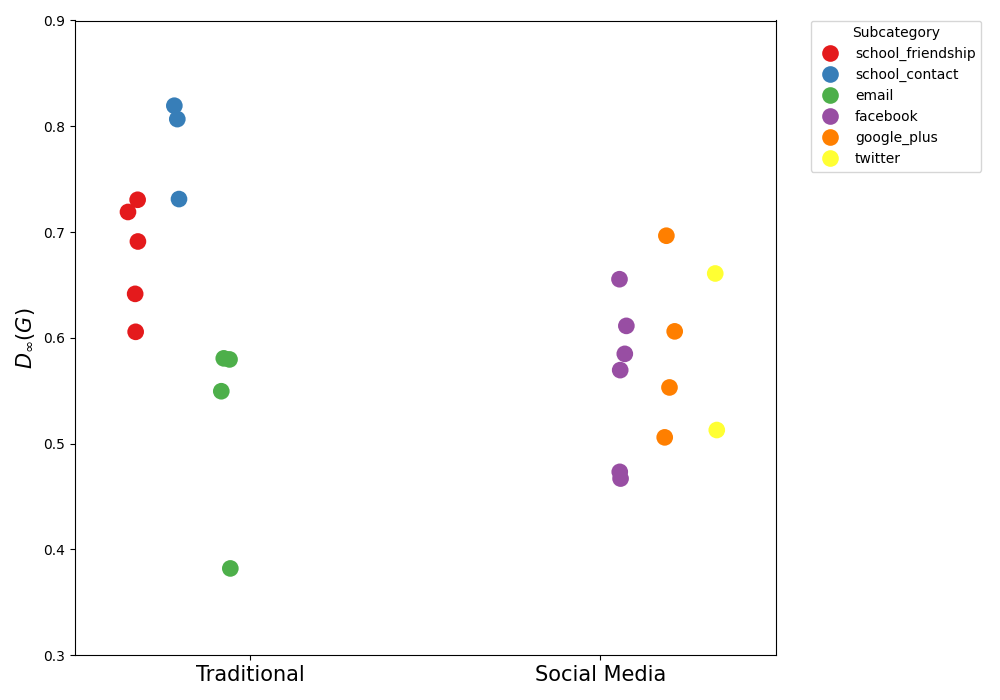

In [29]:
# result_dict = import_from_json(f"./simulation_results/5000_(11-03-38).json")
result_dict = import_from_json(f"./simulation_results/iterations-5000_samplesize-400_timestamp-11-03-38.json")
# result_dict = import_from_json(f"./simulation_results/iterations-2000_samplesize-400_edged-True_timestamp-11-15-37.json")

omit_network = ["facebook_wall"]
for i, net in enumerate(result_dict["name"]):
    if net in omit_network:
        result_dict["div_ind"].pop(i)
        result_dict["name"].pop(i)
        result_dict["category"].pop(i)
        result_dict["off_on"].pop(i)
filtered_network_list = [net_data for net_data in network_list if net_data[0] not in omit_network]
network_list = filtered_network_list

plot_map = {
    "offline": "Traditional",
    "online": "Social Media",
    "school_friendship": "Friendship",
    "school_contact": "Physical Contact",
    "email": "Email",
    "facebook": "Facebook",
    "twitter": "Twitter",
    "google_plus": "Google+",
    "div_ind": "$D_\infty (G)$",
}

plt.figure(figsize=(10, 7))
plt.clf()
sns.stripplot(
    data=result_dict, 
    x="off_on", 
    y="div_ind",
    hue="category",
    palette="Set1",
    dodge=0.5, 
    jitter=True,
    size=12,
) 

plt.legend(
    title="Subcategory",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0
)
plt.xticks([0, 1], ["Traditional", "Social Media"], fontsize=15)
plt.yticks(np.arange(0.3, 1.0, 0.1))
plt.ylim(0.3, 0.9)
plt.xlabel("")
plt.ylabel(plot_map["div_ind"], fontsize=15)
plt.tight_layout()
plt.show()


C:\Users\Alex\AppData\Local\Temp\ipykernel_17716\3814184447.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.pointplot(


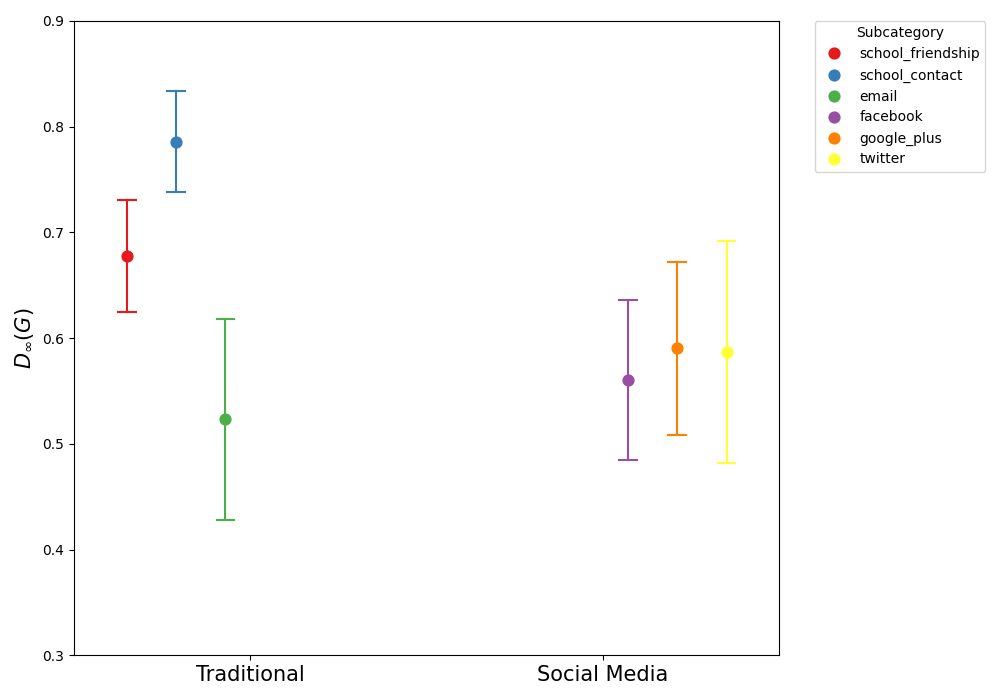

In [ ]:
# plt.clf()
sns.pointplot(
    data=result_dict,
    x="off_on",              # grouping on x-axis (e.g., 'offline' vs 'online')
    y="div_ind",             # the diversity index
    hue="category",          # one mean + std per category in each off_on group
    dodge=0.7,              # separate the categories on x-axis
    palette="Set1",
    errorbar="sd",           # standard deviation as error bar
    markers="o",
    capsize=0.05,             # small cap on error bars (optional)
    errwidth=1.5,            # thickness of error bars
    linestyles=""            # no connecting lines between points
)
plt.legend(
    title="Subcategory",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0
)
plt.xticks([0, 1], ["Traditional", "Social Media"], fontsize=15)
plt.yticks(np.arange(0.3, 1.0, 0.1))
plt.ylim(0.3, 0.9)
plt.xlabel("")
plt.ylabel(plot_map["div_ind"], fontsize=15)
plt.tight_layout()
plt.show()

In [31]:
ax = sns.pointplot('sex', 'tip', hue='smoker',
    data=tips, dodge=True, join=False, ci=None)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over
errors = tips.groupby(['smoker', 'sex']).std()['tip']
colors = ['steelblue']*2 + ['coral']*2
ax.errorbar(x_coords, y_coords, yerr=errors,
    ecolor=colors, fmt=' ', zorder=-1)

NameError: name 'tips' is not defined

In [ ]:
# # get the net, category, off_on of the network with the highest & lowest diversity index
# # max_result_ind = np.argmax(result_dict["div_ind"]) 
# # min_result_ind = np.argmin(result_dict["div_ind"])

# # result_dict_ind = lambda ind: {
# #     "name": result_dict["name"][ind],
# #     "category": result_dict["category"][ind],
# #     "off_on": result_dict["off_on"][ind],
# #     "div_ind": result_dict["div_ind"][ind]
# # }

# sorted_networks = zip(
#     range(len(result_dict["div_ind"])),
#     result_dict["div_ind"],
#     sorted(
#         network_list,
#         key=lambda x: result_dict["div_ind"][result_dict["name"].index(x[0])],
#         reverse=True)
#     )
# print(sorted_networks)


# for i, div_ind, (name, category, off_on) in sorted_networks:

#     # if i == 4:
#     #     extreme = "max"
#     # # elif i == len(result_dict["div_ind"]) - 1:
#     # #     extreme = "min"
#     # else:
#     #     continue

#     extreme = str(i+1) + "th"

#     data_path = os.path.join(source_dir, f"{name}.edge")
#     G = nx.read_edgelist(data_path, nodetype=int, data=(("weight", float),))
#     G = G.to_undirected()

#     print(f"{extreme} diversity index: {div_ind:.2f}")
#     print(f"Network: {name}")

#     if i == len(result_dict["div_ind"]) - 1:

#         ani = animate_simulation(G, iterations=100, fps=5, num_opinions=5, r=0.01, cutoff_div_index=0)
#         save_animation(ani, filename="opinion_dispersion_min.gif")

